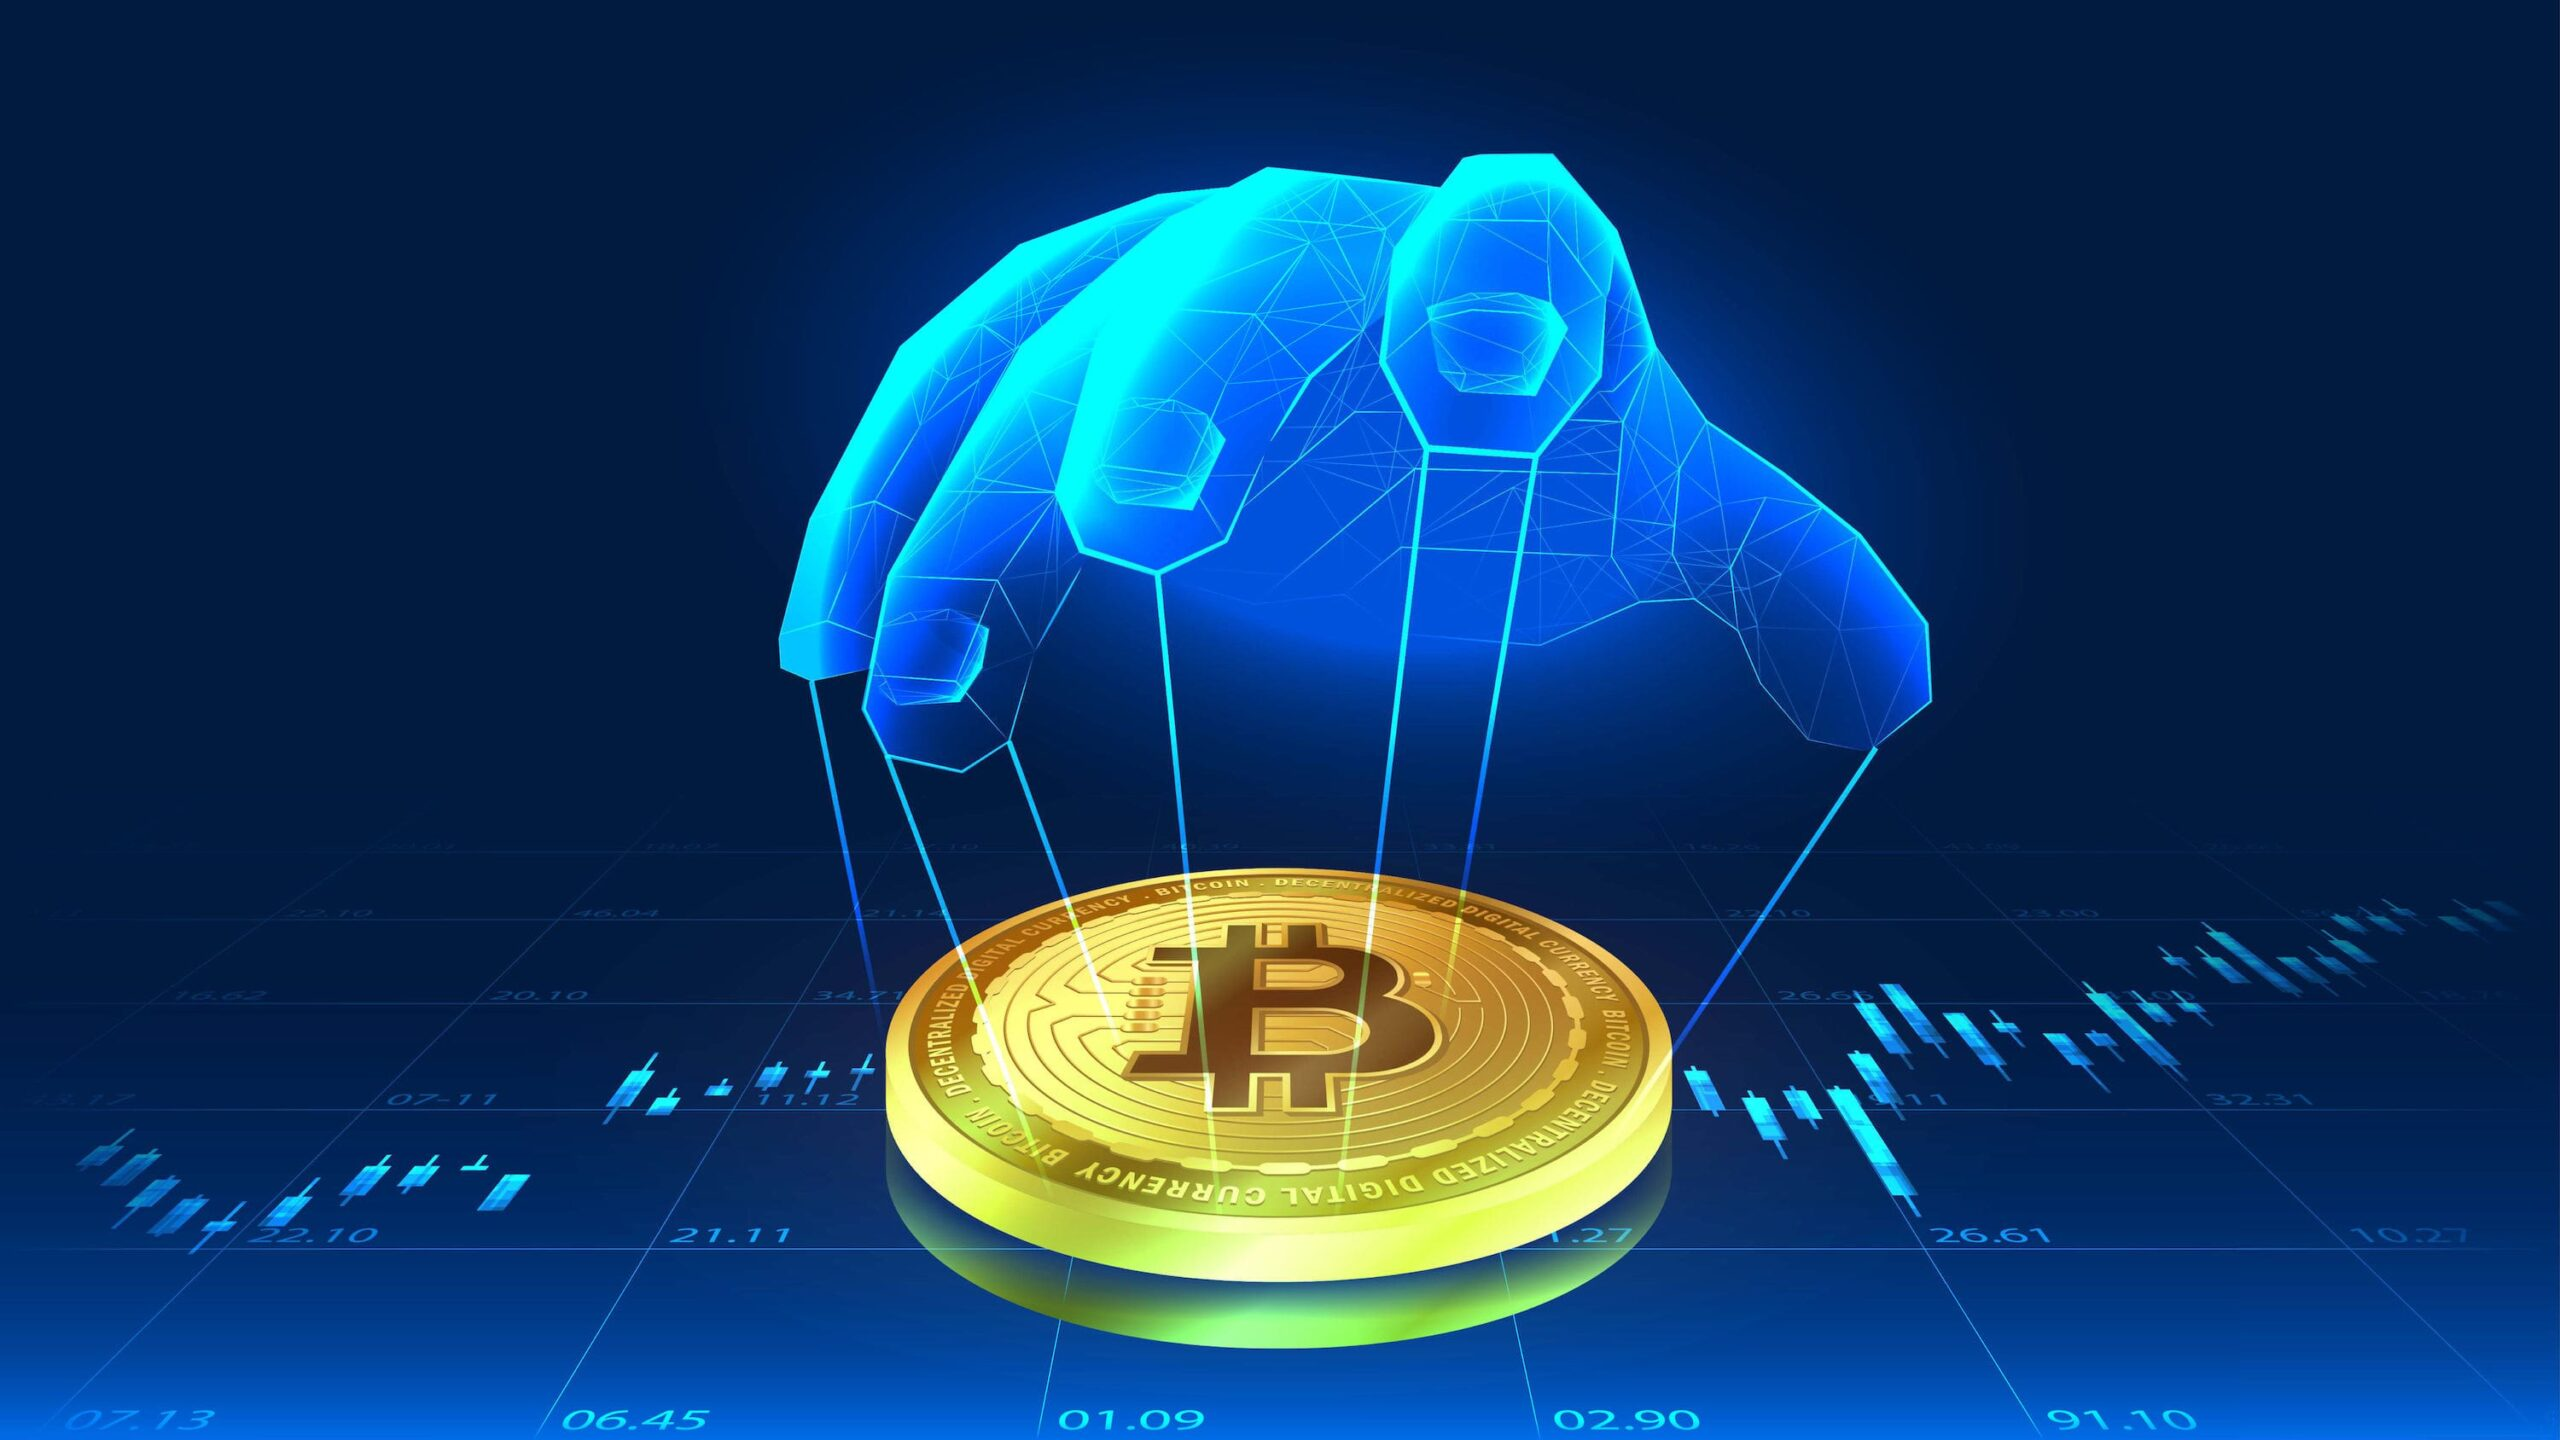

In [1]:
import os
from IPython.display import Image, display

file_path = '/kaggle/input/btc-image/btce2-min-scaled-1.jpg'

display(Image(filename=file_path))

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

# Reading Datasets

In [3]:
df = pd.read_csv("/kaggle/input/btc-fed-funds-and-m2/bitcoin-and-m2-growth-gl.csv", sep=';')
df.head()

,DateTime,BTC price,M2 Growth YoY (%),M2 Global Supply (USD)
0,2013-05-20 00:00:00,"117,8186364699","5,5654014717",59166686473105
1,2013-05-27 00:00:00,"126,392905903","5,8571414345",59490171457382
2,2013-06-03 00:00:00,"122,9491879018","6,7670545757",60072386054198
3,2013-06-10 00:00:00,"104,3575666277","7,2970858354",60559839608422
4,2013-06-17 00:00:00,"100,1263050847","6,5084553461",59754983891203


In [4]:
df2 = pd.read_csv("/kaggle/input/btc-fed-funds-and-m2/bitcoin-and-fed-funds.csv", sep=';')
df2.head()

,DateTime,BTC price,Fed Funds
0,2011-01-01 00:00:00,"0,3","0,17"
1,2011-01-02 00:00:00,"0,29997",NaN
2,2011-01-03 00:00:00,"0,295",NaN
3,2011-01-04 00:00:00,"0,29895",NaN
4,2011-01-05 00:00:00,"0,2989163022",NaN


# Explorer Data Analysis

In [5]:
df2[df2['Fed Funds'].notna()].head(10)

,DateTime,BTC price,Fed Funds
0,2011-01-01 00:00:00,"0,3","0,17"
31,2011-02-01 00:00:00,"0,7075101169","0,16"
59,2011-03-01 00:00:00,"0,9210968919","0,14"
90,2011-04-01 00:00:00,"0,77411","0,1"
120,2011-05-01 00:00:00,"3,0942275535","0,09"
151,2011-06-01 00:00:00,"9,623777232","0,09"
181,2011-07-01 00:00:00,"15,4203573992","0,07"
212,2011-08-01 00:00:00,"13,0191138469","0,1"
243,2011-09-01 00:00:00,"8,2342816651","0,08"
273,2011-10-01 00:00:00,"5,0340705447","0,07"


In [6]:
df2['Fed Funds'] = df2['Fed Funds'].fillna(method='ffill')
df2.head()

,DateTime,BTC price,Fed Funds
0,2011-01-01 00:00:00,"0,3","0,17"
1,2011-01-02 00:00:00,"0,29997","0,17"
2,2011-01-03 00:00:00,"0,295","0,17"
3,2011-01-04 00:00:00,"0,29895","0,17"
4,2011-01-05 00:00:00,"0,2989163022","0,17"


In [7]:
df.dtypes

DateTime                  object
BTC price                 object
M2 Growth YoY (%)         object
M2 Global Supply (USD)     int64
dtype: object

In [8]:
df2.dtypes

DateTime     object
BTC price    object
Fed Funds    object
dtype: object

In [9]:
df.shape

(599, 4)

In [10]:
df2.shape

(5078, 3)

In [11]:
df['DateTime'] =pd.to_datetime(df['DateTime'])
df2['DateTime'] = pd.to_datetime(df2['DateTime'])
df.DateTime.min(),df.DateTime.max(), df2.DateTime.min(),df2.DateTime.max()

(Timestamp('2013-05-20 00:00:00'),
 Timestamp('2024-11-25 00:00:00'),
 Timestamp('2011-01-01 00:00:00'),
 Timestamp('2024-12-05 00:00:00'))

In [12]:
df['M2_Supply'] = df['M2 Global Supply (USD)'] / 10**12
df.drop('M2 Global Supply (USD)', axis=1, inplace=True)
df2.drop('BTC price', axis=1, inplace=True)

In [13]:
df.isnull().sum()

DateTime             0
BTC price            0
M2 Growth YoY (%)    0
M2_Supply            0
dtype: int64

In [14]:
df2.isnull().sum()

DateTime     0
Fed Funds    0
dtype: int64

In the Fed Funds column, only the values ​​on the 1st of the month are filled.

Other values ​​appear as nan.
Therefore, we fill the na values ​​with the values ​​on the 1st of the month.

In [15]:
df['BTC price'] = df['BTC price'].str.replace(',', '.').astype(float)
df['M2 Growth YoY (%)'] = df['M2 Growth YoY (%)'].str.replace(',', '.').astype(float)
df2['Fed Funds'] = df2['Fed Funds'].str.replace(',','.').astype(float)

In [16]:
df = pd.merge(df,df2, on='DateTime', how='left')
df.head()

,DateTime,BTC price,M2 Growth YoY (%),M2_Supply,Fed Funds
0,2013-05-20,117.819,5.565,59.167,0.110
1,2013-05-27,126.393,5.857,59.490,0.110
2,2013-06-03,122.949,6.767,60.072,0.090
3,2013-06-10,104.358,7.297,60.560,0.090
4,2013-06-17,100.126,6.508,59.755,0.090


## Correlation Heatmap

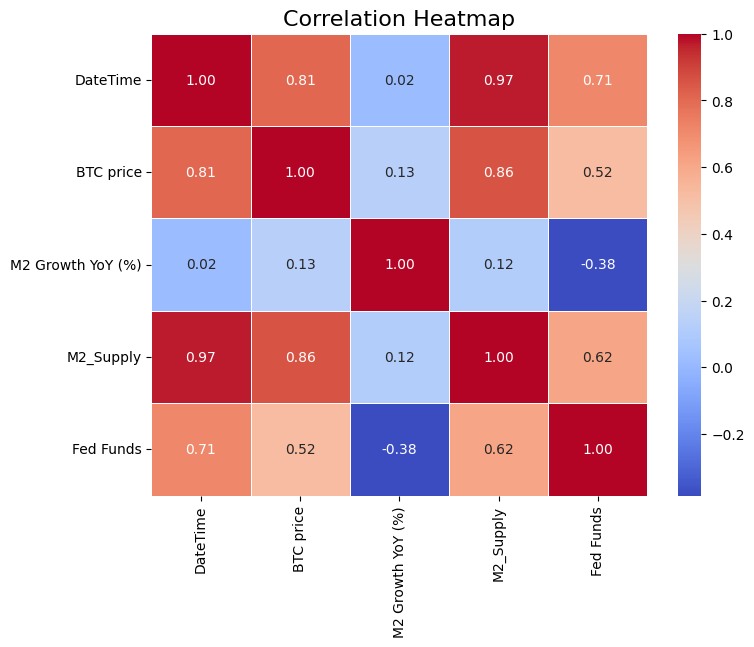

In [17]:

plt.figure(figsize=(8, 6))  # Grafik boyutunu ayarlama
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

1. Global M2 Supply is almost always increasing over time. (0.97 correlation)

- Therefore, fiat currencies will constantly experience inflation.

2. The correlation between Bitcoin and Global M2 Supply, which opposes fiat currencies, is quite high at 0.86.

- Bitcoin is progressing in line with its purpose.

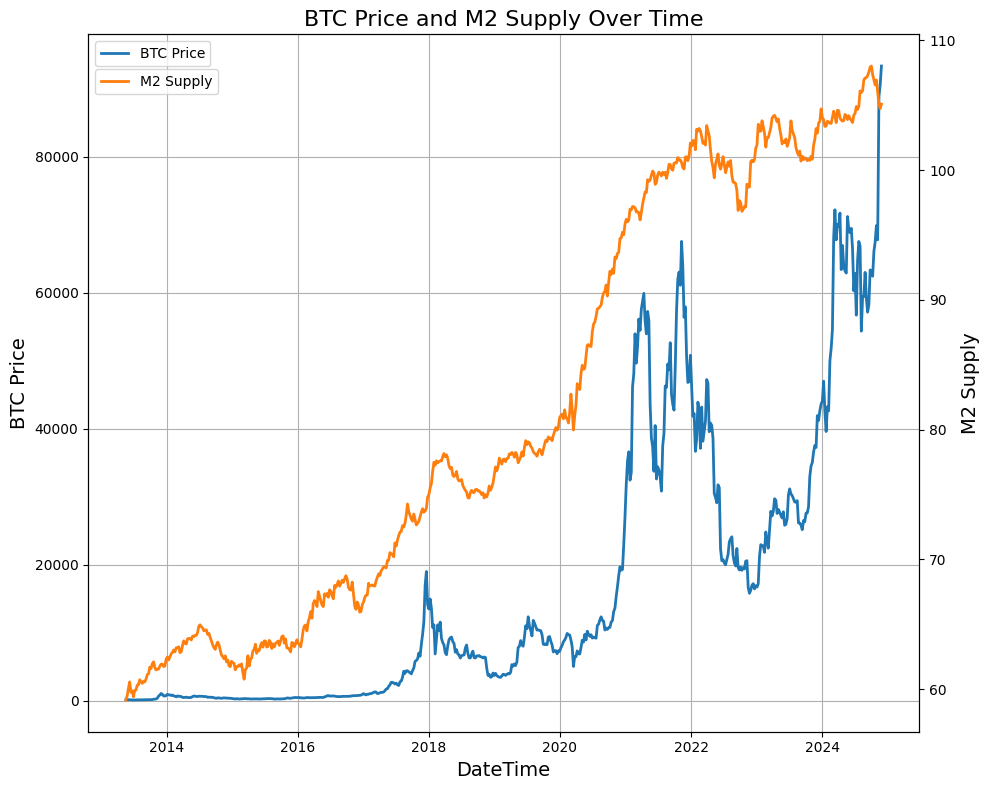

In [18]:
# Chart size
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# Plotting BTC price on primary y-axis
ax1.plot(df['DateTime'], df['BTC price'], label='BTC Price', color='tab:blue', linewidth=2)

# Plotting M2 Supply on the secondary y-axis
ax2.plot(df['DateTime'], df['M2_Supply'], label='M2 Supply', color='tab:orange', linewidth=2)

# Titles ve Labels
ax1.set_title('BTC Price and M2 Supply Over Time', fontsize=16)
ax1.set_xlabel('DateTime', fontsize=14)
ax1.set_ylabel('BTC Price', fontsize=14)
ax2.set_ylabel('M2 Supply', fontsize=14)

# To make the X-axis format more readable
plt.xticks(rotation=45, fontsize=10)

# Add legend for both axes
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.96))

# Add Grid
ax1.grid(True)

# Show Chart
plt.tight_layout()
plt.show()

# FEATURE ENGINEERING

## Date Variables

In [19]:
def create_date_features(df, date_column):
    df['month'] = df[date_column].dt.month
    df['week_of_year'] = df[date_column].dt.isocalendar().week
    df['year'] = df[date_column].dt.year
    df['quarter'] = df[date_column].dt.quarter
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df

df = create_date_features(df, 'DateTime')

## Random Noise
Why is random noise added?
1. Preventing Overfitting
2. Data Augmentation
3. Improving Numerical Stability
4. Reducing Hidden Bias in Data
5. For Simulation and Testing

In [20]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

## Lag/Shifted Features

In [21]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['btc_lag_' + str(lag)] = dataframe['BTC price'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91,92,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,
                       350,351,352,352,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,
                       538,539,540,541,542,
                       718,719,720,721,722])

## Rolling Mean Features

In [22]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['btc_roll_mean_' + str(window)] = dataframe['BTC price']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

df = roll_mean_features(df, [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720])

## Exponentially Weighted Mean Features

In [23]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe['BTC price'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720]

df = ewm_features(df, alphas, lags)

## Special Dates

In [24]:
#After Halving
df[df['DateTime']> '2024-04-20'].head()

,DateTime,BTC price,M2 Growth YoY (%),M2_Supply,Fed Funds,month,week_of_year,year,quarter,is_year_start,is_year_end,btc_lag_91,btc_lag_92,btc_lag_170,btc_lag_171,btc_lag_172,btc_lag_173,btc_lag_174,btc_lag_175,btc_lag_176,btc_lag_177,btc_lag_178,btc_lag_179,btc_lag_180,btc_lag_181,btc_lag_182,btc_lag_183,btc_lag_184,btc_lag_185,btc_lag_186,btc_lag_187,btc_lag_188,btc_lag_189,btc_lag_190,btc_lag_350,btc_lag_351,btc_lag_352,btc_lag_354,btc_lag_355,btc_lag_356,btc_lag_357,btc_lag_358,btc_lag_359,btc_lag_360,btc_lag_361,btc_lag_362,btc_lag_363,btc_lag_364,btc_lag_365,btc_lag_366,btc_lag_367,btc_lag_368,btc_lag_369,btc_lag_370,btc_lag_538,btc_lag_539,btc_lag_540,btc_lag_541,btc_lag_542,btc_lag_718,btc_lag_719,btc_lag_720,btc_lag_721,btc_lag_722,btc_roll_mean_91,btc_roll_mean_92,btc_roll_mean_178,btc_roll_mean_179,btc_roll_mean_180,btc_roll_mean_181,btc_roll_mean_182,btc_roll_mean_359,btc_roll_mean_360,btc_roll_mean_361,btc_roll_mean_449,btc_roll_mean_450,btc_roll_mean_451,btc_roll_mean_539,btc_roll_mean_540,btc_roll_mean_541,btc_roll_mean_629,btc_roll_mean_630,btc_roll_mean_631,btc_roll_mean_720,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_178,sales_ewm_alpha_095_lag_179,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_359,sales_ewm_alpha_095_lag_360,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_449,sales_ewm_alpha_095_lag_450,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_539,sales_ewm_alpha_095_lag_540,sales_ewm_alpha_095_lag_541,sales_ewm_alpha_095_lag_629,sales_ewm_alpha_095_lag_630,sales_ewm_alpha_095_lag_631,sales_ewm_alpha_095_lag_720,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_92,sales_ewm_alpha_09_lag_178,sales_ewm_alpha_09_lag_179,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_181,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_359,sales_ewm_alpha_09_lag_360,sales_ewm_alpha_09_lag_361,sales_ewm_alpha_09_lag_449,sales_ewm_alpha_09_lag_450,sales_ewm_alpha_09_lag_451,sales_ewm_alpha_09_lag_539,sales_ewm_alpha_09_lag_540,sales_ewm_alpha_09_lag_541,sales_ewm_alpha_09_lag_629,sales_ewm_alpha_09_lag_630,sales_ewm_alpha_09_lag_631,sales_ewm_alpha_09_lag_720,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_92,sales_ewm_alpha_08_lag_178,sales_ewm_alpha_08_lag_179,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_181,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_359,sales_ewm_alpha_08_lag_360,sales_ewm_alpha_08_lag_361,sales_ewm_alpha_08_lag_449,sales_ewm_alpha_08_lag_450,sales_ewm_alpha_08_lag_451,sales_ewm_alpha_08_lag_539,sales_ewm_alpha_08_lag_540,sales_ewm_alpha_08_lag_541,sales_ewm_alpha_08_lag_629,sales_ewm_alpha_08_lag_630,sales_ewm_alpha_08_lag_631,sales_ewm_alpha_08_lag_720,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_92,sales_ewm_alpha_07_lag_178,sales_ewm_alpha_07_lag_179,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_181,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_359,sales_ewm_alpha_07_lag_360,sales_ewm_alpha_07_lag_361,sales_ewm_alpha_07_lag_449,sales_ewm_alpha_07_lag_450,sales_ewm_alpha_07_lag_451,sales_ewm_alpha_07_lag_539,sales_ewm_alpha_07_lag_540,sales_ewm_alpha_07_lag_541,sales_ewm_alpha_07_lag_629,sales_ewm_alpha_07_lag_630,sales_ewm_alpha_07_lag_631,sales_ewm_alpha_07_lag_720,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_92,sales_ewm_alpha_05_lag_178,sales_ewm_alpha_05_lag_179,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_181,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_359,sales_ewm_alpha_05_lag_360,sales_ewm_alpha_05_lag_361,sales_ewm_alpha_05_lag_449,sales_ewm_alpha_05_lag_450,sales_ewm_alpha_05_lag_451,sales_ewm_alpha_05_lag_539,sales_ewm_alpha_05_lag_540,sales_ewm_alpha_05_lag_541,sales_ewm_alpha_05_lag_629,sales_ewm_alpha_05_lag_630,sales_ewm_alpha_05_lag_631,sales_ewm_alpha_05_lag_720
567,2024-04-22,66944.596,-0.214,103.778,5.330,4,17,2024,2,0,0,20226.063,20749.841,27042.559,22937.694,19286.426,19184.331,19662.796,18373.696,16741.544,15320.603,13593.904,13079.476,

In [25]:
#We put the date a little earlier because the news can be priced in.
df["is_halving_date"] = '2012_Halving'
df.loc[df["DateTime"]> "2016-07-01" ,"is_halving_date"]= '2016_Halving'
df.loc[df["DateTime"]> "2020-05-01" ,"is_halving_date"]= '2020_Halving'
df.loc[df["DateTime"]> "2024-04-10" ,"is_halving_date"]= '2024_Halving'

In [26]:
#After US Elections
df[df['DateTime']> '2024-11-01'].head()

,DateTime,BTC price,M2 Growth YoY (%),M2_Supply,Fed Funds,month,week_of_year,year,quarter,is_year_start,is_year_end,btc_lag_91,btc_lag_92,btc_lag_170,btc_lag_171,btc_lag_172,btc_lag_173,btc_lag_174,btc_lag_175,btc_lag_176,btc_lag_177,btc_lag_178,btc_lag_179,btc_lag_180,btc_lag_181,btc_lag_182,btc_lag_183,btc_lag_184,btc_lag_185,btc_lag_186,btc_lag_187,btc_lag_188,btc_lag_189,btc_lag_190,btc_lag_350,btc_lag_351,btc_lag_352,btc_lag_354,btc_lag_355,btc_lag_356,btc_lag_357,btc_lag_358,btc_lag_359,btc_lag_360,btc_lag_361,btc_lag_362,btc_lag_363,btc_lag_364,btc_lag_365,btc_lag_366,btc_lag_367,btc_lag_368,btc_lag_369,btc_lag_370,btc_lag_538,btc_lag_539,btc_lag_540,btc_lag_541,btc_lag_542,btc_lag_718,btc_lag_719,btc_lag_720,btc_lag_721,btc_lag_722,btc_roll_mean_91,btc_roll_mean_92,btc_roll_mean_178,btc_roll_mean_179,btc_roll_mean_180,btc_roll_mean_181,btc_roll_mean_182,btc_roll_mean_359,btc_roll_mean_360,btc_roll_mean_361,btc_roll_mean_449,btc_roll_mean_450,btc_roll_mean_451,btc_roll_mean_539,btc_roll_mean_540,btc_roll_mean_541,btc_roll_mean_629,btc_roll_mean_630,btc_roll_mean_631,btc_roll_mean_720,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_178,sales_ewm_alpha_095_lag_179,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_359,sales_ewm_alpha_095_lag_360,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_449,sales_ewm_alpha_095_lag_450,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_539,sales_ewm_alpha_095_lag_540,sales_ewm_alpha_095_lag_541,sales_ewm_alpha_095_lag_629,sales_ewm_alpha_095_lag_630,sales_ewm_alpha_095_lag_631,sales_ewm_alpha_095_lag_720,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_92,sales_ewm_alpha_09_lag_178,sales_ewm_alpha_09_lag_179,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_181,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_359,sales_ewm_alpha_09_lag_360,sales_ewm_alpha_09_lag_361,sales_ewm_alpha_09_lag_449,sales_ewm_alpha_09_lag_450,sales_ewm_alpha_09_lag_451,sales_ewm_alpha_09_lag_539,sales_ewm_alpha_09_lag_540,sales_ewm_alpha_09_lag_541,sales_ewm_alpha_09_lag_629,sales_ewm_alpha_09_lag_630,sales_ewm_alpha_09_lag_631,sales_ewm_alpha_09_lag_720,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_92,sales_ewm_alpha_08_lag_178,sales_ewm_alpha_08_lag_179,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_181,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_359,sales_ewm_alpha_08_lag_360,sales_ewm_alpha_08_lag_361,sales_ewm_alpha_08_lag_449,sales_ewm_alpha_08_lag_450,sales_ewm_alpha_08_lag_451,sales_ewm_alpha_08_lag_539,sales_ewm_alpha_08_lag_540,sales_ewm_alpha_08_lag_541,sales_ewm_alpha_08_lag_629,sales_ewm_alpha_08_lag_630,sales_ewm_alpha_08_lag_631,sales_ewm_alpha_08_lag_720,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_92,sales_ewm_alpha_07_lag_178,sales_ewm_alpha_07_lag_179,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_181,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_359,sales_ewm_alpha_07_lag_360,sales_ewm_alpha_07_lag_361,sales_ewm_alpha_07_lag_449,sales_ewm_alpha_07_lag_450,sales_ewm_alpha_07_lag_451,sales_ewm_alpha_07_lag_539,sales_ewm_alpha_07_lag_540,sales_ewm_alpha_07_lag_541,sales_ewm_alpha_07_lag_629,sales_ewm_alpha_07_lag_630,sales_ewm_alpha_07_lag_631,sales_ewm_alpha_07_lag_720,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_92,sales_ewm_alpha_05_lag_178,sales_ewm_alpha_05_lag_179,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_181,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_359,sales_ewm_alpha_05_lag_360,sales_ewm_alpha_05_lag_361,sales_ewm_alpha_05_lag_449,sales_ewm_alpha_05_lag_450,sales_ewm_alpha_05_lag_451,sales_ewm_alpha_05_lag_539,sales_ewm_alpha_05_lag_540,sales_ewm_alpha_05_lag_541,sales_ewm_alpha_05_lag_629,sales_ewm_alpha_05_lag_630,sales_ewm_alpha_05_lag_631,sales_ewm_alpha_05_lag_720,is_halving_date
595,2024-11-04,67779.097,5.135,106.024,4.830,11,45,2024,4,0,0,22928.770,21182.776,32833.606,33912.010,34374.557,32584.246,40453.769,33726.957,37316.923,38631.411,4349

In [27]:
df["is_us_elections"] = 0
df.loc[df["DateTime"].isin(["2016-11-14","2020-11-09","2021-11-11"]) ,"is_us_elections"]=1

In [28]:
#ETF News and Trump Wins News
df['is_big_expectation'] = 0
df.loc[df["DateTime"].between("2023-10-16", "2024-01-07"), 'is_big_expectation'] = 1
df.loc[df["DateTime"].between("2024-10-12", "2024-11-20"), 'is_big_expectation'] = 1


# ENCODING

In [29]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['quarter','is_halving_date', 'month'])
df.head()

,DateTime,BTC price,M2 Growth YoY (%),M2_Supply,Fed Funds,week_of_year,year,is_year_start,is_year_end,btc_lag_91,btc_lag_92,btc_lag_170,btc_lag_171,btc_lag_172,btc_lag_173,btc_lag_174,btc_lag_175,btc_lag_176,btc_lag_177,btc_lag_178,btc_lag_179,btc_lag_180,btc_lag_181,btc_lag_182,btc_lag_183,btc_lag_184,btc_lag_185,btc_lag_186,btc_lag_187,btc_lag_188,btc_lag_189,btc_lag_190,btc_lag_350,btc_lag_351,btc_lag_352,btc_lag_354,btc_lag_355,btc_lag_356,btc_lag_357,btc_lag_358,btc_lag_359,btc_lag_360,btc_lag_361,btc_lag_362,btc_lag_363,btc_lag_364,btc_lag_365,btc_lag_366,btc_lag_367,btc_lag_368,btc_lag_369,btc_lag_370,btc_lag_538,btc_lag_539,btc_lag_540,btc_lag_541,btc_lag_542,btc_lag_718,btc_lag_719,btc_lag_720,btc_lag_721,btc_lag_722,btc_roll_mean_91,btc_roll_mean_92,btc_roll_mean_178,btc_roll_mean_179,btc_roll_mean_180,btc_roll_mean_181,btc_roll_mean_182,btc_roll_mean_359,btc_roll_mean_360,btc_roll_mean_361,btc_roll_mean_449,btc_roll_mean_450,btc_roll_mean_451,btc_roll_mean_539,btc_roll_mean_540,btc_roll_mean_541,btc_roll_mean_629,btc_roll_mean_630,btc_roll_mean_631,btc_roll_mean_720,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_178,sales_ewm_alpha_095_lag_179,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_359,sales_ewm_alpha_095_lag_360,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_449,sales_ewm_alpha_095_lag_450,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_539,sales_ewm_alpha_095_lag_540,sales_ewm_alpha_095_lag_541,sales_ewm_alpha_095_lag_629,sales_ewm_alpha_095_lag_630,sales_ewm_alpha_095_lag_631,sales_ewm_alpha_095_lag_720,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_92,sales_ewm_alpha_09_lag_178,sales_ewm_alpha_09_lag_179,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_181,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_359,sales_ewm_alpha_09_lag_360,sales_ewm_alpha_09_lag_361,sales_ewm_alpha_09_lag_449,sales_ewm_alpha_09_lag_450,sales_ewm_alpha_09_lag_451,sales_ewm_alpha_09_lag_539,sales_ewm_alpha_09_lag_540,sales_ewm_alpha_09_lag_541,sales_ewm_alpha_09_lag_629,sales_ewm_alpha_09_lag_630,sales_ewm_alpha_09_lag_631,sales_ewm_alpha_09_lag_720,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_92,sales_ewm_alpha_08_lag_178,sales_ewm_alpha_08_lag_179,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_181,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_359,sales_ewm_alpha_08_lag_360,sales_ewm_alpha_08_lag_361,sales_ewm_alpha_08_lag_449,sales_ewm_alpha_08_lag_450,sales_ewm_alpha_08_lag_451,sales_ewm_alpha_08_lag_539,sales_ewm_alpha_08_lag_540,sales_ewm_alpha_08_lag_541,sales_ewm_alpha_08_lag_629,sales_ewm_alpha_08_lag_630,sales_ewm_alpha_08_lag_631,sales_ewm_alpha_08_lag_720,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_92,sales_ewm_alpha_07_lag_178,sales_ewm_alpha_07_lag_179,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_181,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_359,sales_ewm_alpha_07_lag_360,sales_ewm_alpha_07_lag_361,sales_ewm_alpha_07_lag_449,sales_ewm_alpha_07_lag_450,sales_ewm_alpha_07_lag_451,sales_ewm_alpha_07_lag_539,sales_ewm_alpha_07_lag_540,sales_ewm_alpha_07_lag_541,sales_ewm_alpha_07_lag_629,sales_ewm_alpha_07_lag_630,sales_ewm_alpha_07_lag_631,sales_ewm_alpha_07_lag_720,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_92,sales_ewm_alpha_05_lag_178,sales_ewm_alpha_05_lag_179,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_181,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_359,sales_ewm_alpha_05_lag_360,sales_ewm_alpha_05_lag_361,sales_ewm_alpha_05_lag_449,sales_ewm_alpha_05_lag_450,sales_ewm_alpha_05_lag_451,sales_ewm_alpha_05_lag_539,sales_ewm_alpha_05_lag_540,sales_ewm_alpha_05_lag_541,sales_ewm_alpha_05_lag_629,sales_ewm_alpha_05_lag_630,sales_ewm_alpha_05_lag_631,sales_ewm_alpha_05_lag_720,is_us_elections,is_big_expectation,quarter_1,quarter_2,quarter_3,quarter_4,is_halving_date_2012_Halving,is_halving_date_2016_Halving,is_halving_date_2020_Halving,is_halving_date_2024_Halving,month

# LOG Transformation

In [30]:
df['BTC price'] = np.log1p(df["BTC price"].values)
df['M2_Supply'] = np.log1p(df["M2_Supply"].values)

#Custom Cost Function
SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

In [31]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

# Time-Based Validation Sets

In [32]:
# Train set until 8th month of 2024.
train = df.loc[(df["DateTime"] < "2024-09-01"), :]

# Validation set for the last 3 months of 2024.
val = df.loc[(df["DateTime"] >= "2024-09-01"), :]

cols = [col for col in train.columns if col not in ['DateTime', 'M2 Growth YoY (%)', "BTC price"]]

Y_train = train['BTC price']
X_train = train[cols]

Y_val = val['BTC price']
X_val = val[cols]

# Control
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((586,), (586, 201), (13,), (13, 201))

## LightGBM Model

In [33]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(params=lgb_params,
    train_set=lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    num_boost_round=lgb_params['num_boost_round'],
    feval=lgbm_smape,
    callbacks=[lgb.early_stopping(lgb_params['early_stopping_rounds']),
        lgb.log_evaluation(10)])

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 200 rounds
[10]	training's l1: 1.41955	training's SMAPE: 112.163	valid_1's l1: 2.28739	valid_1's SMAPE: 162.819
[20]	training's l1: 1.16543	training's SMAPE: 98.1781	valid_1's l1: 1.96931	valid_1's SMAPE: 150.642
[30]	training's l1: 0.956188	training's SMAPE: 84.5175	valid_1's l1: 1.68593	valid_1's SMAPE: 137.052
[40]	training's l1: 0.785847	training's SMAPE: 71.9706	valid_1's l1: 1.43576	valid_1's SMAPE: 122.659
[50]	training's l1: 0.645796	training's SMAPE: 60.6626	valid_1's l1: 1.25899	valid_1's SMAPE: 111.075
[60]	training's l1: 0.533067	training's SMAPE: 50.9976	valid_1's l1: 1.09645	valid_1's SMAPE: 99.3359
[70]	training's l1: 0.440573	training's SMAPE: 42.6892	valid_1's l1: 0.960385	valid_1's SMAPE: 88.7708
[80]	training's l1: 0.365274	training's SMAPE: 35.7097	valid_1's 

24.28421980339556

In [34]:
df_final =df.copy()
df_final.loc[df_final['DateTime']>= '2024-09-01', 'BTC price'] = np.expm1(y_pred_val)
df_final = df_final[df_final['DateTime']>='2024-09-01']
df.loc[df['DateTime']>= '2024-09-01', 'BTC price'] = np.expm1(Y_val)
df.loc[df['DateTime']< '2024-09-01', 'BTC price'] = np.expm1(df['BTC price'])

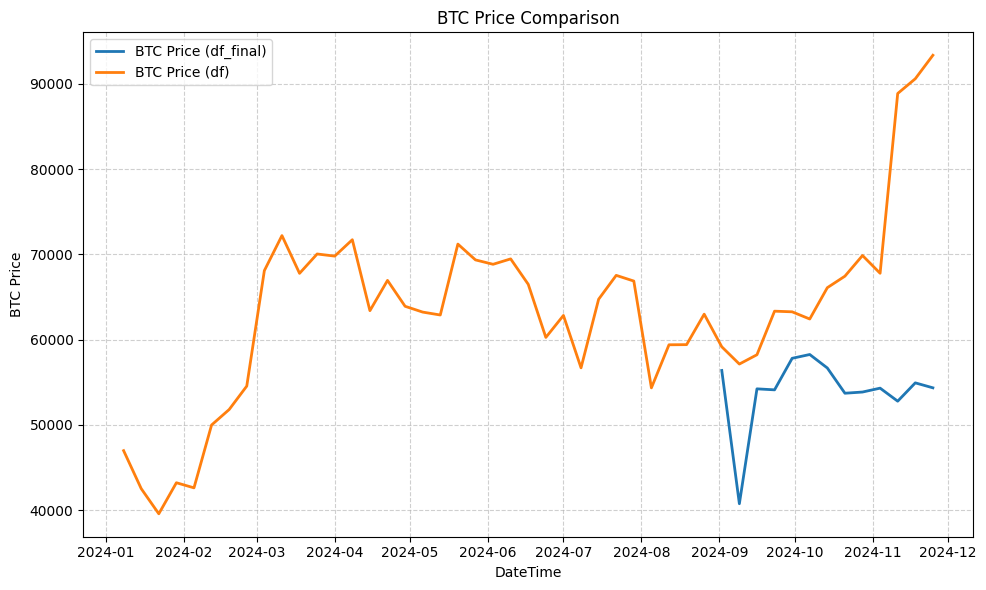

In [35]:
plt.figure(figsize=(10, 6))
df_final_filtered = df_final[df_final['DateTime']>'2024-01-01']
df_filtered = df[df['DateTime']>'2024-01-01']
plt.plot(df_final_filtered['DateTime'], df_final_filtered['BTC price'], label='BTC Price (df_final)', color='tab:blue', linewidth=2)
plt.plot(df_filtered['DateTime'], df_filtered['BTC price'], label='BTC Price (df)', color='tab:orange', linewidth=2)

plt.title('BTC Price Comparison')
plt.xlabel('DateTime')
plt.ylabel('BTC Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# FEATURES IMPORTANCES LEVEL

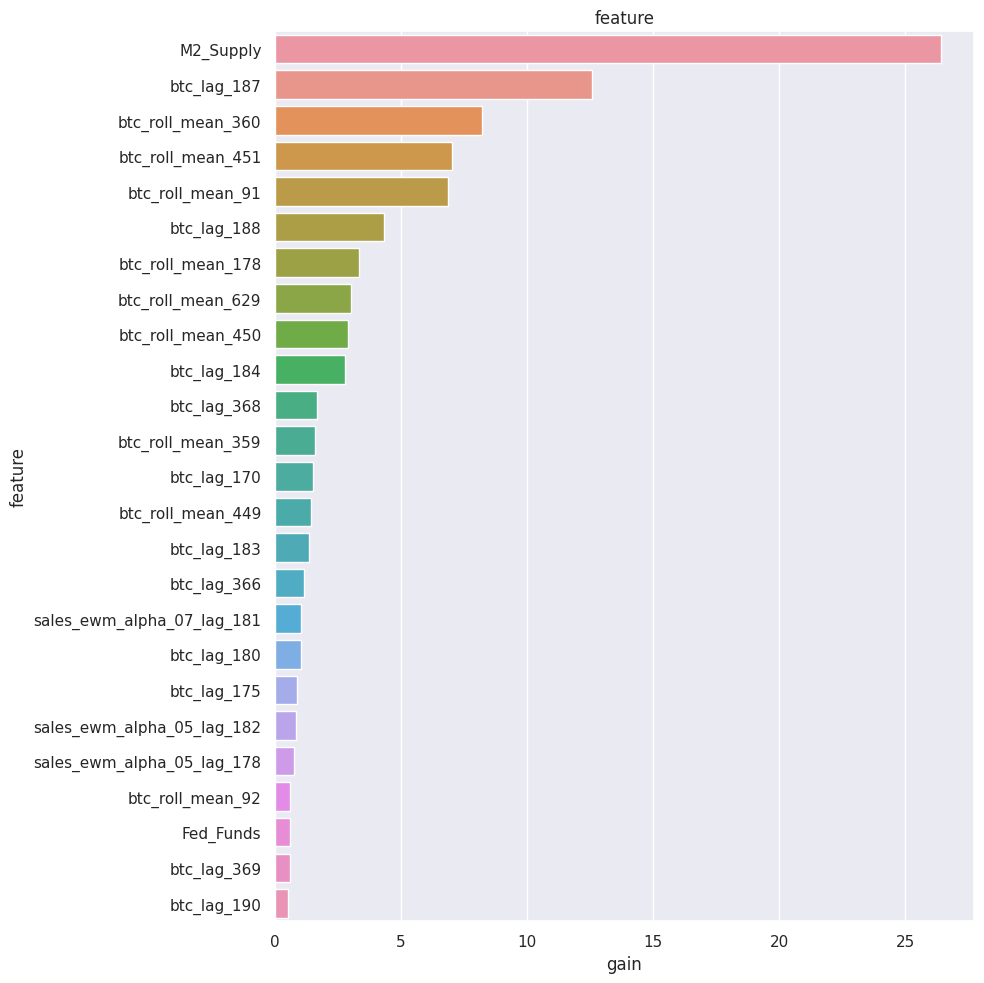

In [36]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


plot_lgb_importances(model, num=30, plot=True)

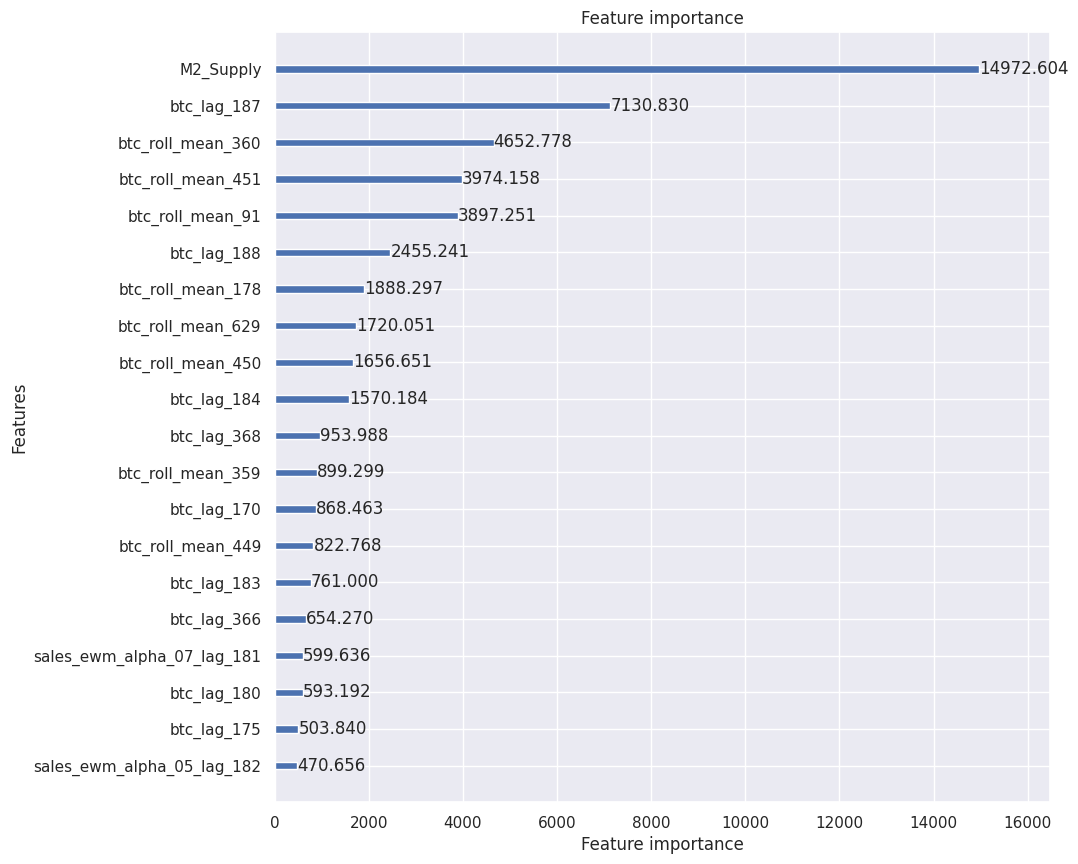

In [37]:
lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

# RESULTS
- As can be seen, the most important variable that determines the price of Bitcoin is the Global M2 money supply.

- This situation also fits well with the mentality of Bitcoin's emergence.

- The SMAPE value did not come as we wanted.

- The reason for this was the victory of the pro-crypto presidential candidate in the US elections. And the sharp upward price movement that emerged with this.